In [1]:
import pickle
from tqdm.auto import tqdm
import numpy as np

from sklearn.preprocessing import StandardScaler

import torch
import torch.nn.functional as F
from torch.optim import Adam

import matplotlib.pyplot as plt

import INN

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')
batch_size = 256
n_epochs = 10

Using device: cpu


In [3]:
with open('../data/data_train.pt', 'rb') as file:
    X_train, y_train = pickle.load(file)

print(f'{X_train.shape = }')
print(f'{y_train.shape = }')

with open('../data/data_test.pt', 'rb') as file:
    X_test, y_test = pickle.load(file)

print(f'{X_test.shape = }')
print(f'{y_test.shape = }')

sc_X_train = StandardScaler()
X_train_scaled = torch.Tensor(sc_X_train.fit_transform(X_train))
X_test_scaled = torch.Tensor(sc_X_train.transform(X_test))

y_train = torch.Tensor(y_train)
y_test = torch.Tensor(y_test)

X_train.shape = (2521156, 28)
y_train.shape = (2521156, 2)
X_test.shape = (630290, 28)
y_test.shape = (630290, 2)


In [4]:
inn = INN.INN(X_train.shape[1], y_train.shape[1], 1)

In [5]:
optimizer = Adam(inn.parameters(), lr=1e-3)

loss_history = {
    'bce': [],
    'kl': [],
    'ld': []
}

for i_epoch in range(n_epochs):

    inn.train()

    for i in tqdm(range(int(np.ceil(len(X_train_scaled) / batch_size)))):
        X = X_train_scaled[i * batch_size: (i+1) * batch_size].to(device)
        y = y_train[i * batch_size: (i+1) * batch_size].to(device)

        optimizer.zero_grad()
        loss = 0
        
        # --- FORWARD ---
        y_pred, z_pred = inn.forward(X)
        y_pred = torch.sigmoid(y_pred)

        # y loss
        loss += F.binary_cross_entropy(y_pred, y)
        loss_history['bce'].append(F.binary_cross_entropy(y_pred, y))
        # z loss
        loss += torch.mean(torch.sum(z_pred**2, dim=-1)) / 2
        loss_history['kl'].append(torch.mean(torch.sum(z_pred**2, dim=-1)) / 2)
        

        # --- INVERSE ---
        if torch.isnan(y_pred).any():
            print(f'{y_pred = }')
        X_pred = inn.inverse(y_pred, z_pred)

        # x loss
        loss -= torch.mean(inn.logdet_sum)
        loss_history['ld'].append(torch.mean(inn.logdet_sum))

        loss.backward()
        optimizer.step()

 39%|███▉      | 3826/9849 [00:17<00:27, 221.47it/s]


KeyboardInterrupt: 

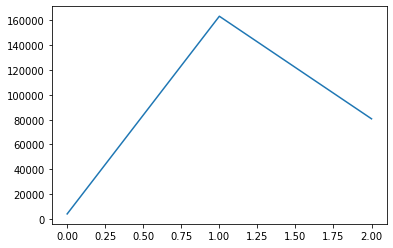

In [10]:
# plt.plot([loss.detach().numpy() for loss in loss_history['bce']])
# plt.plot([loss.detach().numpy() for loss in loss_history['kl']])
# plt.plot([-loss.detach().numpy() for loss in loss_history['ld']])

plt.plot([sum([loss.detach().numpy() for loss in losses]) for losses in loss_history.values()])